## TIES relative binding free energy application KAS-GP Implementation

Run this notebook to reproduce the Kernelized Active Subapce with Gaussian Process (KAS-GP) results for the TIES relative binding free energy application application.

## Install MOGP

The KAS-GP method is implemented in MOGP.
Uncomment to install (development branch)

In [1]:
# ! pip install git+https://github.com/alan-turing-institute/mogp-emulator.git@devel

  Cloning https://github.com/alan-turing-institute/mogp-emulator.git (to revision devel) to /private/var/folders/7m/0rv6nshj07z3x9cglcfzm45m0000gn/T/pip-req-build-b_cd41w7
  Running command git clone --filter=blob:none --quiet https://github.com/alan-turing-institute/mogp-emulator.git /private/var/folders/7m/0rv6nshj07z3x9cglcfzm45m0000gn/T/pip-req-build-b_cd41w7
  Running command git checkout -b devel --track origin/devel
  Switched to a new branch 'devel'
  Branch 'devel' set up to track remote branch 'devel' from 'origin'.
  Resolved https://github.com/alan-turing-institute/mogp-emulator.git to commit d974b1af6bf55741b037f45cf107dc51a1eb5432
  Preparing metadata (setup.py) ... done
  Created wheel for mogp-emulator: filename=mogp_emulator-0.8.0.dev3-py3-none-any.whl size=195902 sha256=a572d03000348051f91aec54863cce91bb3cfc7147d3faebdd0ae9894f2f5592
  Stored in directory: /private/var/folders/7m/0rv6nshj07z3x9cglcfzm45m0000gn/T/pip-ephem-wheel-cache-4z0twjds/wheels/67/48/0e/6ffd1b91e

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from mogp_emulator import gKDR, GaussianProcess, fit_GP_MAP


RandomSeed = 2023
np.random.seed(RandomSeed)

%matplotlib inline
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams['savefig.dpi'] = 300

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [3]:
# input parameters
params = pd.read_csv('./data_ties/ties_inputs.csv')
param_names = params.keys()
params = params.values

n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_min = np.min(params, axis=0)
p_max = np.max(params, axis=0)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

print('There are %d inputs' % D)

There are 169 inputs


### Load output samples

Load the corresponding Monte Carlo outputs, in the case the relative binding free energy predictions.

In [4]:
QoI = 'relative_binding_energy'
output = pd.read_csv('./data_ties/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [5]:
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
    samples = samples - np.mean(samples)/np.std(samples)
else:
    samples = np.mean(output, axis=1, keepdims=True)
    samples = (samples - np.mean(samples))/np.std(samples)

### Train / test split

In [6]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select $d$

This is the dimension of the active subspace.

In [7]:
d = 1

### Cross Validation for Kernel used in KAS

  0%|          | 0/5 [00:00<?, ?it/s]

Matrix not positive definite, skipping this iteration
Matrix not positive definite, skipping this iteration


 40%|████      | 2/5 [03:45<05:39, 113.03s/it]

Matrix not positive definite, skipping this iteration


 80%|████████  | 4/5 [07:28<01:51, 111.89s/it]

Matrix not positive definite, skipping this iteration
Matrix not positive definite, skipping this iteration


100%|██████████| 5/5 [09:20<00:00, 112.07s/it]


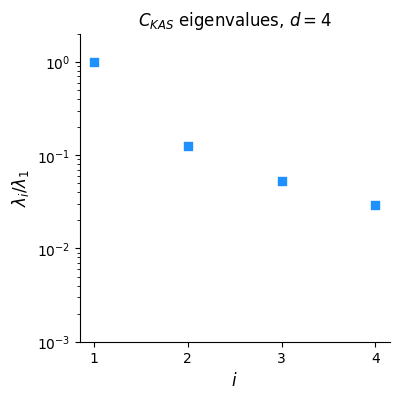

In [8]:
# Cross Validation for Kernel used in KAS
# if the fit_GP_MAP fail increase the number of tries
num_tries_fit_gp = 3

def cross_validation_gKDR(data_input, data_output, K, gp=None, cxs=None, cys=None, 
                          num_fold=5, grid_size=5, num_tries_fit_gp=1):   
    if cxs is None:
        cxs = np.array([0.5+0.5*i for i in range(grid_size)])
    if cys is None:
        cys = np.array([0.5+0.5*i for i in range(grid_size)])
    lx = len(cxs)
    ly = len(cys)
    assert lx == ly, "cxs and cys must have the same length"

    _, d = data_input.shape
    params = []
    errors = []

    e_star = np.inf
    x_star = None
    y_star = None
    best_L = np.zeros(d)

    for x in tqdm(cxs):
        for y in cys:
            min_L = np.zeros(d)
            params.append((x,y))
            e = np.zeros(num_fold)
            L = np.zeros((num_fold, d))
            data_set = np.concatenate([data_input, data_output], axis=1)
            data_set = np.random.permutation(data_set)
            data_set = np.array_split(data_set, num_fold)
            for k_index in range(num_fold):
                test_input, test_output = data_set[k_index][:,:-1], data_set[k_index][:,-1]
                train = np.concatenate([data_set[i] for i in range(num_fold) if i != k_index])
                train_input, train_output = train[:,:-1], train[:,-1]

                gkdr = gKDR(train_input, train_output, X_scale=x, Y_scale=y, K=4)
                reduced_train_input = gkdr(X=train_input)
                reduced_test_input = gkdr(X=test_input)

                gp = GaussianProcess(reduced_train_input, train_output, nugget="fit")
                gp_map = fit_GP_MAP(gp, n_tries=num_tries_fit_gp)
                pred_means, _, _ = gp_map.predict(reduced_test_input)
                e[k_index] = np.log(np.linalg.norm(pred_means - test_output))
                L[k_index] = np.hstack((gkdr.L[0]*2, gkdr.L[1:]))
            mean_error = np.mean(e)
            mean_L = np.mean(L, axis=0)
            errors.append(mean_error)
            if mean_error < e_star:
                e_star = mean_error
                x_star = x
                y_star = y
                best_L = mean_L

    return params, errors, best_L, (x_star, y_star, e_star)

# Cross validation and hyperparameter tuning for kernel hyperparameters
hyper_params, errors, best_L, (x_star, y_star, e_star) = cross_validation_gKDR(params_train, samples_train, K=d, 
                                                                           gp=GaussianProcess, grid_size=5, 
                                                                           num_tries_fit_gp=num_tries_fit_gp)


# Visualize the Eigen values
d_vals = 4

# KAS eigenvalues
eigvals_C_kas = best_L[0:d_vals] 
eigvals_C_kas /= eigvals_C_kas[0]


# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', title=r'%s eigenvalues, $d=%d$' % (r'$C_{KAS}$', d_vals), ylim=[1e-3, 2])
ax1.set_ylabel(r'$\lambda_i/\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
ax1.scatter(range(1, d_vals + 1), eigvals_C_kas, marker='s', color='dodgerblue')
ax1.set_xticks(np.arange(1, d_vals + 1, 1))
sns.despine(top=True)

### Fit a Gaussian Process Surrogate 

In [9]:
gkdr = gKDR(params_train, samples_train, X_scale=x_star, Y_scale=y_star, K=d)
reduced_params_train = gkdr(X=params_train)
reduced_params_test = gkdr(X=params_test)

gp = GaussianProcess(reduced_params_train, samples_train.flatten(), nugget="fit")
gp_map = fit_GP_MAP(gp)

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [10]:
# run the surrogates at a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
reduced_pred_inputs = gkdr(X=pred_inputs)

gp_samples_pred_mean = np.zeros(n_mc)
gp_samples_pred_std = np.zeros(n_mc)
for i in range(n_mc): 
    gp_samples_pred_mean[i], gp_samples_pred_std[i], _ = gp.predict(reduced_pred_inputs[i])

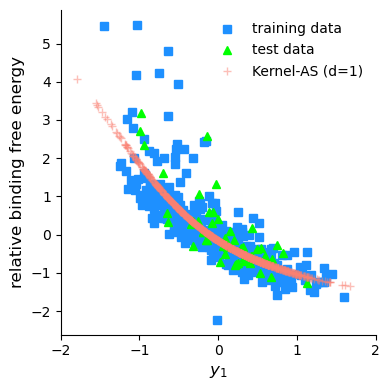

In [15]:
# QoI labels
lbl = {QoI: r'relative binding free energy'}

# plot DAS surrogate
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111,  xlim=[-2,2])    #E11 range
#ax = fig.add_subplot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(reduced_params_train[:,0], samples_train, 's', color='dodgerblue', label='training data') 
ax.plot(reduced_params_test[:,0], samples_test, '^', color='lime', label='test data') 
ax.plot(reduced_pred_inputs[:,0], gp_samples_pred_mean, '+', color='salmon', label='Kernel-AS (d=%d)' % 1, alpha=0.5)
          
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()

### Compute the Sensitivity Index

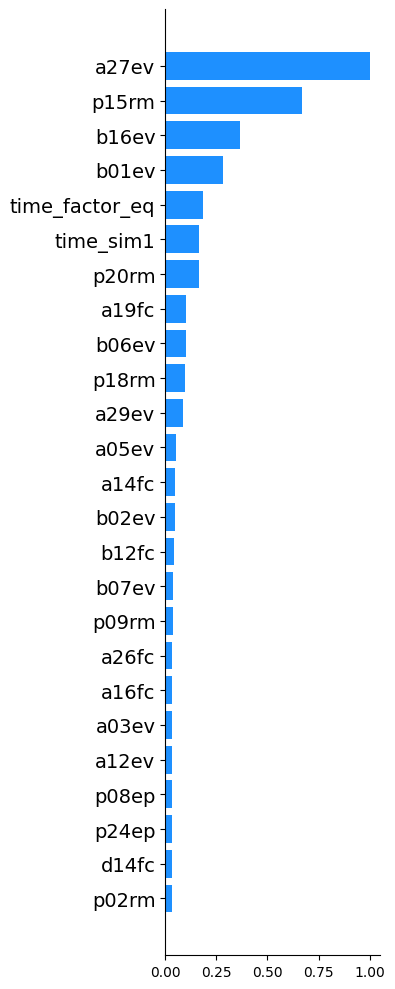

In [11]:
eigen_vec = np.sum((gkdr.L)*gkdr.B**2, axis=1)
sort_index = np.argsort(eigen_vec)[::-1]

fig = plt.figure(figsize=[4, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(25),width=eigen_vec[sort_index][:25]/np.max(eigen_vec),color='dodgerblue')
ax.set_yticks(range(25))
ax.set_yticklabels(param_names[sort_index][0:25], fontsize=14)
ax.invert_yaxis()
sns.despine(top=True)
plt.tight_layout()